In [1]:
library(dplyr)
library(tidyverse)
library(ggplot2)
library(glmnet)
library(corrplot)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.3     v readr   1.3.1
v tibble  3.0.4     v purrr   0.3.2
v tidyr   1.1.3     v stringr 1.4.0
v ggplot2 3.3.3     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()

In [2]:
data = read.csv("Data/precip-summaries.csv")
x = c('DATE','PRCP','SNOW')
df = data[x] %>% drop_na(.)
df$DATE = as.Date(df$DATE, format = "%Y-%m-%d")
head(df)

DATE,PRCP,SNOW
1933-07-01,0,0
1933-07-02,0,0
1933-07-03,0,0
1933-07-04,0,0
1933-07-05,0,0
1933-07-06,0,0


In [3]:
fit = lm(PRCP ~ DATE, data = df)
summary(fit)


Call:
lm(formula = PRCP ~ DATE, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
 -5.94  -5.43  -5.19  -4.96 688.10 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.176e+00  1.980e-01  26.140   <2e-16 ***
DATE        4.104e-05  2.906e-05   1.412    0.158    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 27.37 on 20415 degrees of freedom
Multiple R-squared:  9.766e-05,	Adjusted R-squared:  4.868e-05 
F-statistic: 1.994 on 1 and 20415 DF,  p-value: 0.158


In [4]:
df2 = df %>% mutate(YEAR = as.numeric(format(df$DATE, format="%Y"))) %>% group_by(YEAR) %>% summarise(YRLY_PRCP = sum(PRCP))
head(df2)


`summarise()` ungrouping output (override with `.groups` argument)


YEAR,YRLY_PRCP
1933,92
1934,15
1937,137
1938,302
1939,219
1940,1938


In [5]:
plot1 = df2 %>% ggplot(aes(x = YEAR, y = YRLY_PRCP)) + geom_line() + geom_smooth(method = "lm") +
    xlab("Year") + ylab("Annual Precipitation Accumulation (mm)") + ylim(0, 4000)
ggsave("plot1.png")

Saving 6.67 x 6.67 in image
`geom_smooth()` using formula 'y ~ x'


In [6]:
plot2 = df2 %>% filter(YEAR >= 1980) %>% ggplot(aes(x = YEAR, y = YRLY_PRCP)) + geom_line() + geom_smooth(method = "lm") +
    xlab("Year") + ylab("Annual Precipitation Accumulation (mm)")
ggsave("plot2.png")

Saving 6.67 x 6.67 in image
`geom_smooth()` using formula 'y ~ x'


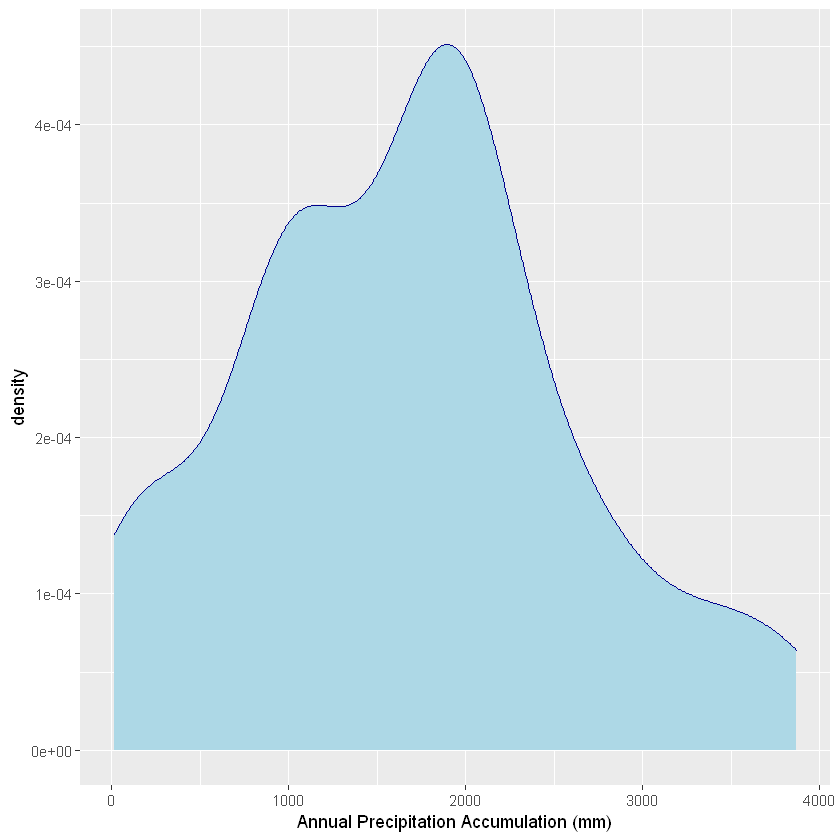

In [7]:
df2 %>% ggplot(aes(YRLY_PRCP)) + geom_density(color="darkblue", fill="lightblue") +
    xlab("Annual Precipitation Accumulation (mm)")

In [17]:
glob = read.csv("Data/glob.csv")
head(glob)

Year,Temp,CO2,CH4,sunspot,volcanic
1880,-0.225,290.7,908,32.24167,0.0000
1881,-0.204,291.2,909,54.30833,0.0000
1882,-0.212,291.7,910,59.60833,0.0000
1883,-0.290,292.1,911,63.63333,0.0572
1884,-0.403,292.6,913,63.50833,0.0897
1885,-0.385,293.0,914,51.95833,0.0138


In [18]:
df3 = inner_join(df2, glob, by = c("YEAR"="Year"))
head(df3)

YEAR,YRLY_PRCP,Temp,CO2,CH4,sunspot,volcanic
1933,92,-0.274,308.6,1102,5.658333,0.0025
1934,15,-0.130,309.0,1107,8.716667,0.0028
1937,137,-0.028,310.0,1133,114.400000,0.0335
1938,302,-0.006,310.2,1137,109.550000,0.0043
1939,219,-0.056,310.3,1140,88.750000,0.0054
1940,1938,0.017,310.4,1144,67.783333,0.0004


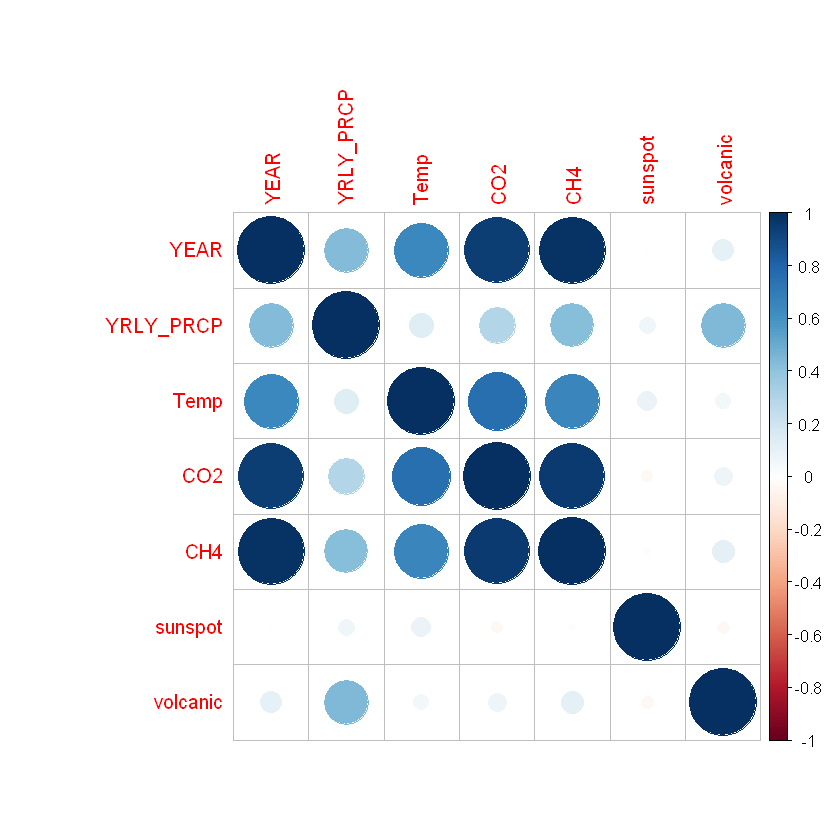

In [22]:
corrplot(cor(df3))

In [52]:
clim_mod = lm(YRLY_PRCP ~ YEAR + Temp + CO2 + CH4 + sunspot + volcanic, data = df3)
summary(clim_mod)


Call:
lm(formula = YRLY_PRCP ~ YEAR + Temp + CO2 + CH4 + sunspot + 
    volcanic, data = df3)

Residuals:
    Min      1Q  Median      3Q     Max 
-1128.9  -566.0  -124.9   379.0  1841.8 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.428e+04  5.009e+04  -1.483 0.143892    
YEAR         4.691e+01  2.728e+01   1.720 0.091216 .  
Temp         2.351e+02  8.633e+02   0.272 0.786397    
CO2         -6.314e+01  1.969e+01  -3.206 0.002262 ** 
CH4          2.876e+00  2.555e+00   1.126 0.265284    
sunspot      7.691e-01  1.774e+00   0.434 0.666320    
volcanic     1.500e+04  3.943e+03   3.805 0.000364 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 700.2 on 54 degrees of freedom
Multiple R-squared:  0.4984,	Adjusted R-squared:  0.4427 
F-statistic: 8.944 on 6 and 54 DF,  p-value: 8.784e-07


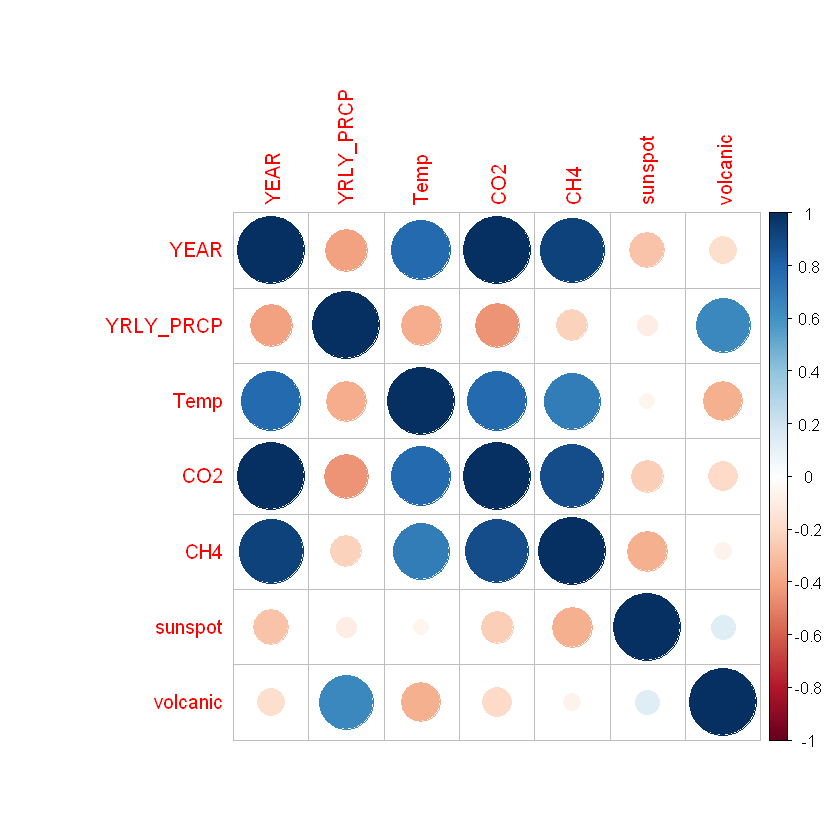

In [34]:
df4 = df3 %>% filter(YEAR>=1980)
corrplot(cor(df4))

In [53]:
clim_mod2 = lm(YRLY_PRCP ~ YEAR + Temp + CO2 + CH4 + sunspot + volcanic, data = df4)
summary(clim_mod2)


Call:
lm(formula = YRLY_PRCP ~ YEAR + Temp + CO2 + CH4 + sunspot + 
    volcanic, data = df4)

Residuals:
   Min     1Q Median     3Q    Max 
-860.4 -328.3 -143.9  217.6 1314.0 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) 253884.063 505840.042   0.502  0.62353   
YEAR          -132.314    282.799  -0.468  0.64708   
Temp          2299.562   1668.616   1.378  0.18979   
CO2              4.506    137.523   0.033  0.97432   
CH4              5.572      7.114   0.783  0.44655   
sunspot         -5.520      3.352  -1.647  0.12181   
volcanic     20319.029   5476.678   3.710  0.00233 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 604.1 on 14 degrees of freedom
Multiple R-squared:  0.6657,	Adjusted R-squared:  0.5224 
F-statistic: 4.645 on 6 and 14 DF,  p-value: 0.008438


In [65]:
co2 = lm(CO2 ~ YEAR, data = df4)
summary(co2)
co2$coef


Call:
lm(formula = CO2 ~ YEAR, data = df4)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0601 -1.0073  0.1554  0.7316  4.5993 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.983e+03  9.042e+01  -32.99   <2e-16 ***
YEAR         1.677e+00  4.542e-02   36.91   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.568 on 19 degrees of freedom
Multiple R-squared:  0.9862,	Adjusted R-squared:  0.9855 
F-statistic:  1362 on 1 and 19 DF,  p-value: < 2.2e-16


(Intercept)         YEAR 
-2983.009456     1.676548

In [66]:
ch4 = lm(CH4 ~ YEAR, data = df4)
summary(ch4)
ch4$coef


Call:
lm(formula = CH4 ~ YEAR, data = df4)

Residuals:
    Min      1Q  Median      3Q     Max 
-67.337  -0.522   8.078  17.432  26.109 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.489e+04  1.608e+03  -9.257 1.80e-08 ***
YEAR         8.338e+00  8.078e-01  10.322 3.15e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 27.88 on 19 degrees of freedom
Multiple R-squared:  0.8487,	Adjusted R-squared:  0.8407 
F-statistic: 106.5 on 1 and 19 DF,  p-value: 3.152e-09


(Intercept)          YEAR 
-14886.992203      8.338465

In [67]:
temp = lm(Temp ~ YEAR, data = df4)
summary(temp)
temp$coef


Call:
lm(formula = Temp ~ YEAR, data = df4)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.14152 -0.08188 -0.02052  0.05727  0.22284 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -30.371161   5.670043  -5.356 3.61e-05 ***
YEAR          0.015357   0.002848   5.392 3.34e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0983 on 19 degrees of freedom
Multiple R-squared:  0.6047,	Adjusted R-squared:  0.5839 
F-statistic: 29.07 on 1 and 19 DF,  p-value: 3.341e-05


(Intercept)         YEAR 
-30.37116142   0.01535702

In [68]:
sun = lm(sunspot ~ YEAR, data = df4)
summary(sun)
sun$coef


Call:
lm(formula = sunspot ~ YEAR, data = df4)

Residuals:
    Min      1Q  Median      3Q     Max 
-70.719 -42.133   3.271  34.170  79.468 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 3920.757   2926.843   1.340    0.196
YEAR          -1.932      1.470  -1.314    0.205

Residual standard error: 50.74 on 19 degrees of freedom
Multiple R-squared:  0.08329,	Adjusted R-squared:  0.03504 
F-statistic: 1.726 on 1 and 19 DF,  p-value: 0.2045


(Intercept)        YEAR 
3920.757375   -1.931842

In [69]:
volc = lm(volcanic ~ YEAR, data = df4)
summary(volc)
volc$coef


Call:
lm(formula = volcanic ~ YEAR, data = df4)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.028326 -0.014910 -0.012455  0.003467  0.099552 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  1.3127317  1.7039924   0.770    0.451
YEAR        -0.0006482  0.0008560  -0.757    0.458

Residual standard error: 0.02954 on 19 degrees of freedom
Multiple R-squared:  0.02929,	Adjusted R-squared:  -0.0218 
F-statistic: 0.5734 on 1 and 19 DF,  p-value: 0.4582


(Intercept)          YEAR 
 1.3127317193 -0.0006481847